In [1]:
#모듈
import numpy as np
import pandas as pd
from konlpy.tag import Okt
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import copy

## 참고사항
- morph2,nouns2는 특수문자만 제거 
- morph3,nouns3는 특수문자 및 불용문자 제거 

In [32]:
df=pd.read_csv('./ML_dataset.csv')
df.tail(1)

,Unnamed: 0,Grade,Hotel,Country,Year,Month,stay_day,member,Room type,Date,Review Title,Review Contents,Point,Point_Index,morphs,nouns,morphs3,nouns3,morphs2,nouns2
30583,30583,1,골든 파크 호텔 제주 (Golden Park Hotel Jeju),대한민국,2022,12,2,나홀로 여행객,"룸 (싱글베드 2개, 금연)",2022년 12월 | 2박,가성비 좋은 호텔,['전반적으로 깨끗하고 뚜벅이 여행에 최고좋은 시외버스터미널이 걸어서 5분이라 제주...,8.0,0.0,"[""['"", '전반', '적', '으로', '깨끗하고', '뚜벅', '이', '여행...","['전반', '뚜벅', '여행', '최고', '시외버스', '터미널', '제주', ...",전반 적 깨끗하고 뚜벅 여행 최고 좋은 시외버스 터미널 걸어서 5분 이라 제주 버...,전반 뚜벅 여행 최고 시외버스 터미널 제주 버스 타고 갈수 한라산 버스 요,[' 전반 적 으로 깨끗하고 뚜벅 이 여행 에 최고 좋은 시외버스 터미널 이 걸어서...,전반 뚜벅 여행 최고 시외버스 터미널 제주 어디 버스 타고 갈수 한라산 버스 요


In [9]:
df["Point_index"] = [1. if Point > 7 else 0. for Point in df["Point"]] # 내용 기준 7점 기준 라벨 정하기
df.tail(1)

,Grade,Hotel,Country,Year,Month,stay_day,member,Room type,Date,Review Title,Review Contents,Point,Point_index,morphs,nouns,morphs2,nouns2
30583,1,골든 파크 호텔 제주 (Golden Park Hotel Jeju),대한민국,2022,12,2,나홀로 여행객,"룸 (싱글베드 2개, 금연)",2022년 12월 | 2박,가성비 좋은 호텔,전반적으로 깨끗하고 뚜벅이 여행에 최고좋은 시외버스터미널이 걸어서 분이라 제주 어디...,8.0,1.0,"[전반, 적, 으로, 깨끗하고, 뚜벅, 이, 여행, 에, 최고, 좋은, 시외버스, ...","[전반, 뚜벅, 여행, 최고, 시외버스, 터미널, 분, 제주, 어디, 버스, 타고,...",전반 적 으로 깨끗하고 뚜벅 이 여행 에 최고 좋은 시외버스 터미널 이 걸어서 분 ...,전반 뚜벅 여행 최고 시외버스 터미널 분 제주 어디 버스 타고 갈수 한라산 버스 요


부정: 4929 긍정: 25655


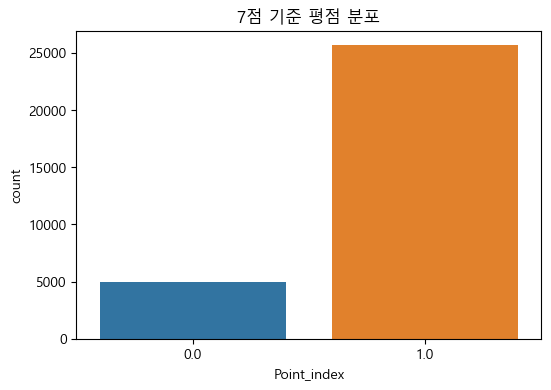

In [14]:
# 평점 변환시 사용하기
plt.rc('font',family='Malgun Gothic')
std = 7  #기준값 설정
df["Point_index"] = [1. if point >= std else 0. for point in df["Point"]]


df_pos = df[df['Point_index']==1] #긍정리뷰 데이터프레임
df_neg = df[df['Point_index']==0] #부정리뷰 데이터프레임

#인덱스별 분포 확인

print("부정:",len(df_neg),"긍정:",len(df_pos))

plt.figure(figsize=(6,4))
plt.title('7점 기준 평점 분포')
plt.grid(False)
sns.countplot(x=df['Point_index'])
plt.show()

In [15]:
# 불용어 (https://www.ranks.nl/stopwords/korean)

korean_stopword='../stopwords.txt'

with open(korean_stopword, encoding='utf-8') as f:
    stopwords=f.readlines()

stoplist=[x.strip() for x in stopwords]

#불용어 추가
add_list=['제주도','호텔','숙소','가성','성비','대비','이용','제주','역시','생각','상태','다만','바로','느낌','신라','직원','가격','위치','시설','조식','객실','그냥','입니다']

for word in add_list:
    stoplist.append(word)

# print(stoplist[-10:])

In [16]:
#특수문자 및 불용문자 제거

import string
string.punctuation

#형태소
df['morphs3'] = df['morphs'].apply(lambda x : ' '.join([i for i in x if i not in stoplist]))
df['morphs3'] = df['morphs3'].apply(lambda x : ''.join([i for i in x if i not in string.punctuation]))

#명사
df['nouns3'] = df['nouns'].apply(lambda x : ' '.join([i for i in x if i not in stoplist]))
df['nouns3'] = df['nouns3'].apply(lambda x : ''.join([i for i in x if i not in string.punctuation]))


In [17]:
#9점이상 6점미만 데이터만 분류(학습용)
df2=copy.deepcopy(df)
df2=df2[(df2['Point']>=9)|(df2['Point']<6)]

In [186]:
from sklearn.feature_extraction.text import CountVectorizer

X1 = df['morphs3']
X2 = df['nouns3']
X3 = df2['morphs3']
X4 = df2['nouns3']

vectorizer = CountVectorizer(lowercase=False)
X1 = vectorizer.fit_transform(X1)
X2 = vectorizer.fit_transform(X2)


vectorizer2 = CountVectorizer(lowercase=False).fit(X3_train)
X3_train = vectorizer2.fit_transform(X3)
X3_test = vectorizer2.fit_transform(X3)
X4_train = vectorizer2.fit_transform(X4)
X4_test = vectorizer2.fit_transform(X4)



In [18]:
# 벡터화 x1, x2 : 8.5기준
# 카운트 기반 벡터화는 카운트 값이 높을수록 중요한 단어로 인식
# 단점 보완 -> tf-idf



#불용문자 추가시 2를 3으로 변경    
X1 = df['morphs3']
X2 = df['nouns3']
y = df['Point_index']


vectorizer = CountVectorizer(lowercase=False)
X1 = vectorizer.fit_transform(X1)
X2 = vectorizer.fit_transform(X2)


# Train data와 test data로 나누기

from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y, test_size = 0.2, random_state=13,stratify=y)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y, test_size = 0.2, random_state=13,stratify=y)




In [19]:
#평점 9점이상 6점미만 데이터만 사용 x3,x4
from sklearn.feature_extraction.text import CountVectorizer

#불용문자 추가시 2를 3으로 변경    
X3 = df2['morphs3']
X4 = df2['nouns3']
y = df2['Point_index']

#벡터화
vectorizer = CountVectorizer(lowercase=False)
X3 = vectorizer.fit_transform(X3)
X4 = vectorizer.fit_transform(X4)

# Train data와 test data로 나누기

from sklearn.model_selection import train_test_split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y, test_size = 0.2, random_state=13)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y, test_size = 0.2, random_state=13) # stratify=y




# 성능 테스트

In [20]:
# 분류기 성능 return 

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.metrics import confusion_matrix
from sklearn import metrics


def get_clf_eval(y_test,pred):
    acc= accuracy_score(y_test, pred)
    pre=precision_score(y_test, pred)
    re=recall_score(y_test, pred)
    f1=f1_score(y_test, pred)
    auc=roc_auc_score(y_test, pred)

    return acc, pre, re,f1, auc


def print_clf_eval(y_test, pred):
    confusion=confusion_matrix(y_test,pred)
    acc,pre,re,f1,auc = get_clf_eval(y_test, pred)

    print('=> confusion matrix')
    print(confusion)
    print('===============')

    print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc,pre))
    print('Recall : {0:.4f}, F1 : {1:.4f}, Auc:{2:.4f}'.format(re,f1,auc))

### 나이브 베이즈  
- parameter = { "alpha" : [0.5,1.0,1.5,2.0] , "fit_prior": [True, False] }, cv=10

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

params = { "alpha" : [0.5,1.0,1.5,2.0] , "fit_prior": [True, False] }


grid_clf = GridSearchCV(model, param_grid=params, cv=10)
grid_clf.fit(X3_train, y3_train)

print(f'최적의 하이퍼 파라미터 : {grid_clf.best_params_}')
print(f'최적의 모델 평균 성능 : {grid_clf.best_score_}')

최적의 하이퍼 파라미터 : {'alpha': 1.0, 'fit_prior': True}
최적의 모델 평균 성능 : 0.9328580344280726


<AxesSubplot: >

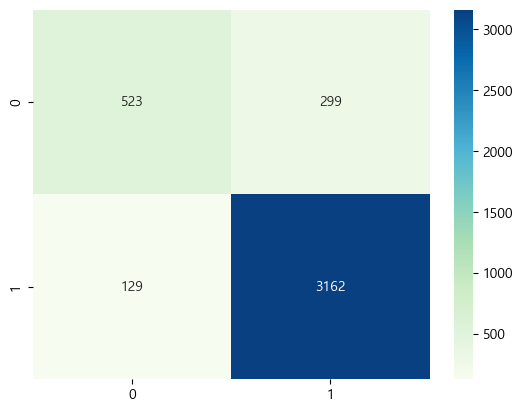

In [79]:
model = MultinomialNB(alpha=1.0, fit_prior=True) # alpha=1.0, fit_prior=True

model.fit(X3_train, y3_train)
pred = model.predict(X3_test)


# confusion matrix plot

conf_matrix = confusion_matrix(y3_test, pred)


sns.heatmap(confusion_matrix(y3_test, pred), annot=True, fmt='d', cmap='GnBu')

나이베이즈 
=> confusion matrix
[[ 325  194]
 [  63 3242]]
Accuracy : 0.9328, Precision : 0.9435
Recall : 0.9809, F1 : 0.9619, Auc:0.8036
로지스틱 회귀 
=> confusion matrix
[[ 294  225]
 [  46 3259]]
Accuracy : 0.9291, Precision : 0.9354
Recall : 0.9861, F1 : 0.9601, Auc:0.7763
랜덤포레스트 
=> confusion matrix
[[ 236  283]
 [  53 3252]]
Accuracy : 0.9121, Precision : 0.9199
Recall : 0.9840, F1 : 0.9509, Auc:0.7193


ValueError: Found input variables with inconsistent numbers of samples: [19120, 3824]

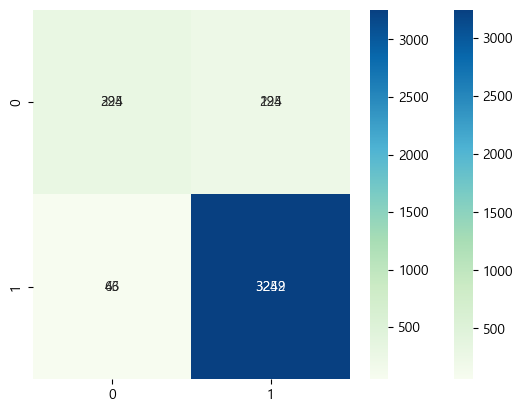

In [50]:
#평점 9점이상 6점미만 데이터만 사용

# 나이베이즈
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB() # alpha=0.5, fit_prior=True

model.fit(X3_train, y3_train)
pred = model.predict(X3_test)

print('나이베이즈 ')
print_clf_eval(y3_test, pred)



# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression
model2 = LogisticRegression()
model2.fit(X3_train,y3_train)
y_pred_test = model2.predict(X3_test)

print('로지스틱 회귀 ')
print_clf_eval(y3_test, y_pred_test)


# 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier

rf_clf=RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)
rf_clf.fit(X3_train, y3_train)
rf_pred=rf_clf.predict(X3_test)

print('랜덤포레스트 ')
print_clf_eval(y3_test, rf_pred)


<AxesSubplot: >

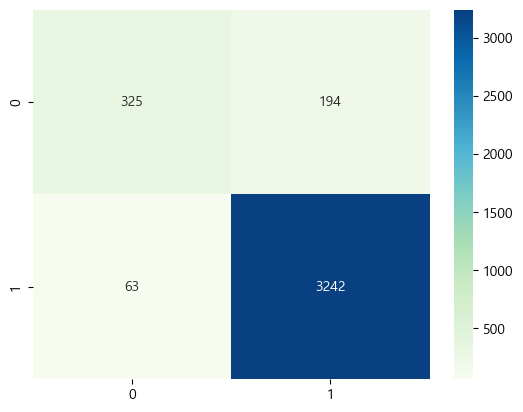

In [53]:
# 나이브베이즈
sns.heatmap(confusion_matrix(y3_test, pred), annot=True, fmt='d', cmap='GnBu')

<AxesSubplot: >

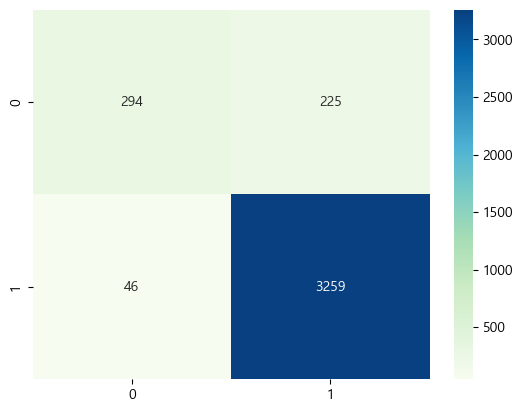

In [54]:
# 로지스틱 회귀
sns.heatmap(confusion_matrix(y3_test, y_pred_test), annot=True, fmt='d', cmap='GnBu')



<AxesSubplot: >

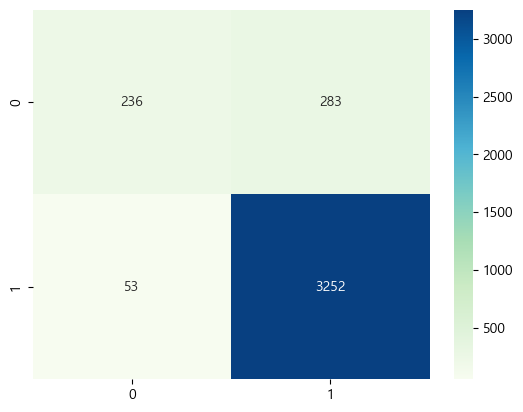

In [55]:
# 랜덤포레스트 
sns.heatmap(confusion_matrix(y3_test, rf_pred), annot=True, fmt='d', cmap='GnBu')

In [ ]:
sns.heatmap(confusion_matrix(y, pred_f), annot=True, fmt='d', cmap='GnBu')

### 로지스틱 회귀 

In [28]:
# LogisticRegression 
# penalty : 규제의 종류(l1, l2, elasticnet, none)
# C : 규제의 강도 (클수록 훈련 복잡 -> 규제 약해짐/ 디폴트 : 1)

from sklearn.model_selection import KFold
params = {
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [ 0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

model2 = LogisticRegression()

kfold = KFold(n_splits=10, shuffle=True, random_state = 1)
grid_clf2 = GridSearchCV(model2, param_grid=params, scoring='f1', cv=kfold)
grid_clf2.fit(X3_train, y3_train)

print(f'최적의 하이퍼 파라미터 : {grid_clf2.best_params_}')
print(f'최적의 모델 평균 성능 : {grid_clf2.best_score_}')

c:\miniconda3\envs\ds_study\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\miniconda3\envs\ds_study\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\miniconda3\envs\ds_study\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\miniconda3\envs\ds_study\lib\site-packages\sklearn\linear_model\

최적의 하이퍼 파라미터 : {'C': 1, 'penalty': 'l2'}
최적의 모델 평균 성능 : 0.9614384062270928


In [32]:
from sklearn.linear_model import LogisticRegression
model2 = LogisticRegression(C=1,penalty='l2')
model2.fit(X3_train,y3_train)
y_pred_test = model2.predict(X3_test)

#로지스틱 성능
print_clf_eval(y3_test, y_pred_test)

=> confusion matrix
[[ 294  225]
 [  46 3259]]
Accuracy : 0.9291, Precision : 0.9354
Recall : 0.9861, F1 : 0.9601, Auc:0.7763


In [157]:
# 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier

rf_clf=RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)
rf_clf.fit(X4_train, y4_train)
rf_pred=rf_clf.predict(X4_test)


print_clf_eval(y4_test, rf_pred)

=> confusion matrix
[[ 218  301]
 [  57 3248]]
Accuracy : 0.9064, Precision : 0.9152
Recall : 0.9828, F1 : 0.9478, Auc:0.7014


In [125]:
# RandomForest
# n_estimators : 사용할 트리의 개수
# max_depth : 생성될 최대 질문 깊이, None은 무한대.

from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [10,100,1000],
    'max_depth' : [None, 2,4,8,10]
}

model4 = RandomForestClassifier(random_state=1)
grid_clf4 = GridSearchCV(model4, param_grid=params, cv=3)
grid_clf4.fit(X4_train, y4_train)

print(f'최적의 하이퍼 파라미터 : {grid_clf4.best_params_}')
print(f'최적의 모델 평균 성능 : {grid_clf4.best_score_}')

최적의 하이퍼 파라미터 : {'max_depth': None, 'n_estimators': 1000}
최적의 모델 평균 성능 : 0.9066421303848761


In [147]:
rf_clf=RandomForestClassifierrandom_state=(13, n_jobs=-1,max_depth=None, n_estimators=1000)
rf_clf.fit(X4_train, y4_train)
rf_pred=rf_clf.predict(X4_test)


print_clf_eval(y4_test, rf_pred)

=> confusion matrix
[[ 210  309]
 [  56 3249]]
Accuracy : 0.9046, Precision : 0.9132
Recall : 0.9831, F1 : 0.9468, Auc:0.6938


In [64]:
# 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier

params={'n_estimators': [10,100],
        'max_depth':[6,8,10,12],
        'min_samples_leaf':[8,12,18],
        'min_samples_split':[8,16,20]}
rf_clf=RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)
rf_clf.fit(X2_train, y2_train)
rf_pred=rf_clf.predict(X2_test)


print_clf_eval(y2_test, rf_pred)

=> confusion matrix
[[ 236  750]
 [ 132 4999]]
Accuracy : 0.8558, Precision : 0.8695
Recall : 0.9743, F1 : 0.9189, Auc:0.6068


# 워드클라우드 확인용 

In [61]:
df.head(1)

,Grade,Hotel,Country,Year,Month,stay_day,member,Room type,Date,Review Title,Review Contents,Point,morphs,nouns,morphs2,nouns2,Point_index,morphs3,nouns3
0,5,메종 글래드 제주 (Maison Glad Jeju),대한민국,2021,5,3,나홀로 여행객,스탠다드 트윈,2021년 5월 | 3박,기대보다 좋았어요,시설이 낡았다는 후기를 보고 별 기대없이 갔는데 박동안 행복하게 보내고 왔습니다 새...,10.0,"[시설, 이, 낡았다는, 후기, 를, 보고, 별, 기대, 없이, 갔는데, 박동, 안...","[시설, 후기, 보고, 별, 기대, 박동, 안, 새, 느낌, 침대, 햇, 다음, 숙...",시설 이 낡았다는 후기 를 보고 별 기대 없이 갔는데 박동 안 행복하게 보내고 왔습...,시설 후기 보고 별 기대 박동 안 새 느낌 침대 햇 다음 숙소 부영 호텔 그랜드 조...,1.0,시설 낡았다는 후기 보고 별 기대 없이 갔는데 박동 안 행복하게 보내고 왔습니다 새...,시설 후기 보고 별 기대 박동 안 새 느낌 침대 햇 숙소 부영 호텔 그랜드 조선 침...


In [375]:

df['Point'].describe()

count    30584.000000
mean         8.548964
std          1.763577
min          2.000000
25%          8.000000
50%          9.200000
75%         10.000000
max         10.000000
Name: Point, dtype: float64

In [67]:
review_corpus=''.join(df['Review Contents'].tolist())
review_corpus_pos=''.join(df[df['Point_index']==1]['Review Contents'].tolist())
review_corpus_neg=''.join(df[df['Point_index']==0]['Review Contents'].tolist())

In [68]:
#한번 실행
tagger=Okt()
morphs=tagger.morphs(review_corpus)
count_review=Counter(morphs)
remove_morphs_counter = Counter({x : count_review[x] for x in count_review if len(x) > 1})
morphs_final = Counter({x : remove_morphs_counter[x]for x in remove_morphs_counter if x not in stopwords})


nouns=tagger.morphs(review_corpus)
count_review=Counter(nouns)
remove_nouns_counter = Counter({x : count_review[x] for x in count_review if len(x) > 1})
nouns_final = Counter({x : remove_nouns_counter[x]for x in remove_nouns_counter if x not in stopwords})

In [69]:
# 긍정
morphs_pos=tagger.morphs(review_corpus_pos)
count_review_pos=Counter(morphs_pos)

nouns_pos=tagger.morphs(review_corpus_pos)
count_review_pos=Counter(nouns_pos)

#부정 리뷰
morphs_neg=tagger.morphs(review_corpus_neg)
count_review_neg=Counter(morphs_neg)

nouns_neg=tagger.morphs(review_corpus_neg)
count_review_neg=Counter(nouns_neg)

In [70]:
#한번 실행

#긍정 리뷰
#morphs_pos=tagger.morphs(review_corpus_pos)
#count_review_pos=Counter(morphs_pos)
remove_morphs_counter_pos = Counter({x : count_review_pos[x] for x in count_review_pos if len(x) > 1})
morphs_final_pos = Counter({x : remove_morphs_counter_pos[x]for x in remove_morphs_counter_pos if x not in stopwords})

#nouns_pos=tagger.morphs(review_corpus_pos)
#count_review_pos=Counter(nouns_pos)
remove_nouns_counter_pos = Counter({x : count_review_neg[x] for x in count_review_pos if len(x) > 1})
nouns_final_pos = Counter({x : remove_nouns_counter_pos[x]for x in remove_nouns_counter_pos if x not in stopwords})

#부정 리뷰
#morphs_neg=tagger.morphs(review_corpus_neg)
#count_review_neg=Counter(morphs_neg)
remove_morphs_counter_neg = Counter({x : count_review_neg[x] for x in count_review_neg if len(x) > 1})
morphs_final_neg = Counter({x : remove_morphs_counter_neg[x]for x in remove_morphs_counter_neg if x not in stopwords})

#nouns_neg=tagger.morphs(review_corpus_neg)
# count_review_neg=Counter(nouns_neg)
remove_nouns_counter_neg = Counter({x : count_review_neg[x] for x in count_review_neg if len(x) > 1})
nouns_final_neg = Counter({x : remove_nouns_counter_neg[x]for x in remove_nouns_counter_neg if x not in stopwords})

In [71]:
# 불용어 (https://www.ranks.nl/stopwords/korean)

korean_stopword='../stopwords.txt'

with open(korean_stopword, encoding='utf-8') as f:
    stopwords=f.readlines()

stoplist=[x.strip() for x in stopwords]

In [72]:
#불용어 추가
add_list=['제주도','호텔','숙소','가성','성비','대비','이용','제주','역시','생각','상태','다만','바로','느낌','신라','직원','가격','위치','시설','조식','객실','그냥','너무','수영장','입니다']


add_list=set(add_list)

for word in add_list:
    stoplist.append(word)



morphs_final = Counter({x : remove_morphs_counter[x]for x in remove_morphs_counter if x not in stoplist})
nouns_final = Counter({x : remove_nouns_counter[x]for x in remove_nouns_counter if x not in stoplist})

morphs_final_pos = Counter({x : remove_morphs_counter_pos[x]for x in remove_morphs_counter_pos if x not in stoplist})
nouns_final_pos = Counter({x : remove_nouns_counter_pos[x]for x in remove_nouns_counter_pos if x not in stoplist})

morphs_final_neg = Counter({x : remove_morphs_counter_neg[x]for x in remove_morphs_counter_neg if x not in stoplist})
nouns_final_neg = Counter({x : remove_nouns_counter_neg[x]for x in remove_nouns_counter_neg if x not in stoplist})

In [132]:
#문자 수 확인용 필요한내용 주석 해제 사용

print(morphs_final.most_common(20))
print(morphs_final_pos.most_common(20))
print(morphs_final_neg.most_common(20))
# print(nouns_final.most_common(20))
# print(nouns_final_pos.most_common(20))
# print(nouns_final_neg.most_common(20))

[('수영장', 4131), ('입니다', 3610), ('하고', 3082), ('좋았어요', 2990), ('좋았습니다', 2976), ('여행', 2815), ('좋아요', 2669), ('좋은', 2620), ('정말', 2593), ('좋고', 2497), ('있어서', 2454), ('공항', 2390), ('분들', 2368), ('깨끗하고', 2194), ('했는데', 2052), ('이라', 2033), ('최고', 2006), ('예약', 1928), ('합니다', 1858), ('주변', 1856)]
[('수영장', 2596), ('입니다', 2401), ('좋았어요', 2253), ('좋았습니다', 2228), ('여행', 1958), ('좋고', 1894), ('좋아요', 1848), ('정말', 1756), ('분들', 1753), ('최고', 1709), ('깨끗하고', 1697), ('하고', 1676), ('좋은', 1664), ('있어서', 1626), ('공항', 1511), ('방문', 1298), ('서비스', 1185), ('좋습니다', 1154), ('했는데', 1149), ('주변', 1122)]
[('수영장', 1537), ('하고', 1404), ('입니다', 1204), ('화장실', 962), ('좋은', 956), ('이라', 940), ('예약', 918), ('했는데', 903), ('청소', 881), ('냄새', 881), ('공항', 880), ('여행', 857), ('정도', 839), ('정말', 837), ('있어서', 828), ('좋아요', 823), ('해서', 804), ('침대', 804), ('좋았습니다', 752), ('소리', 752)]


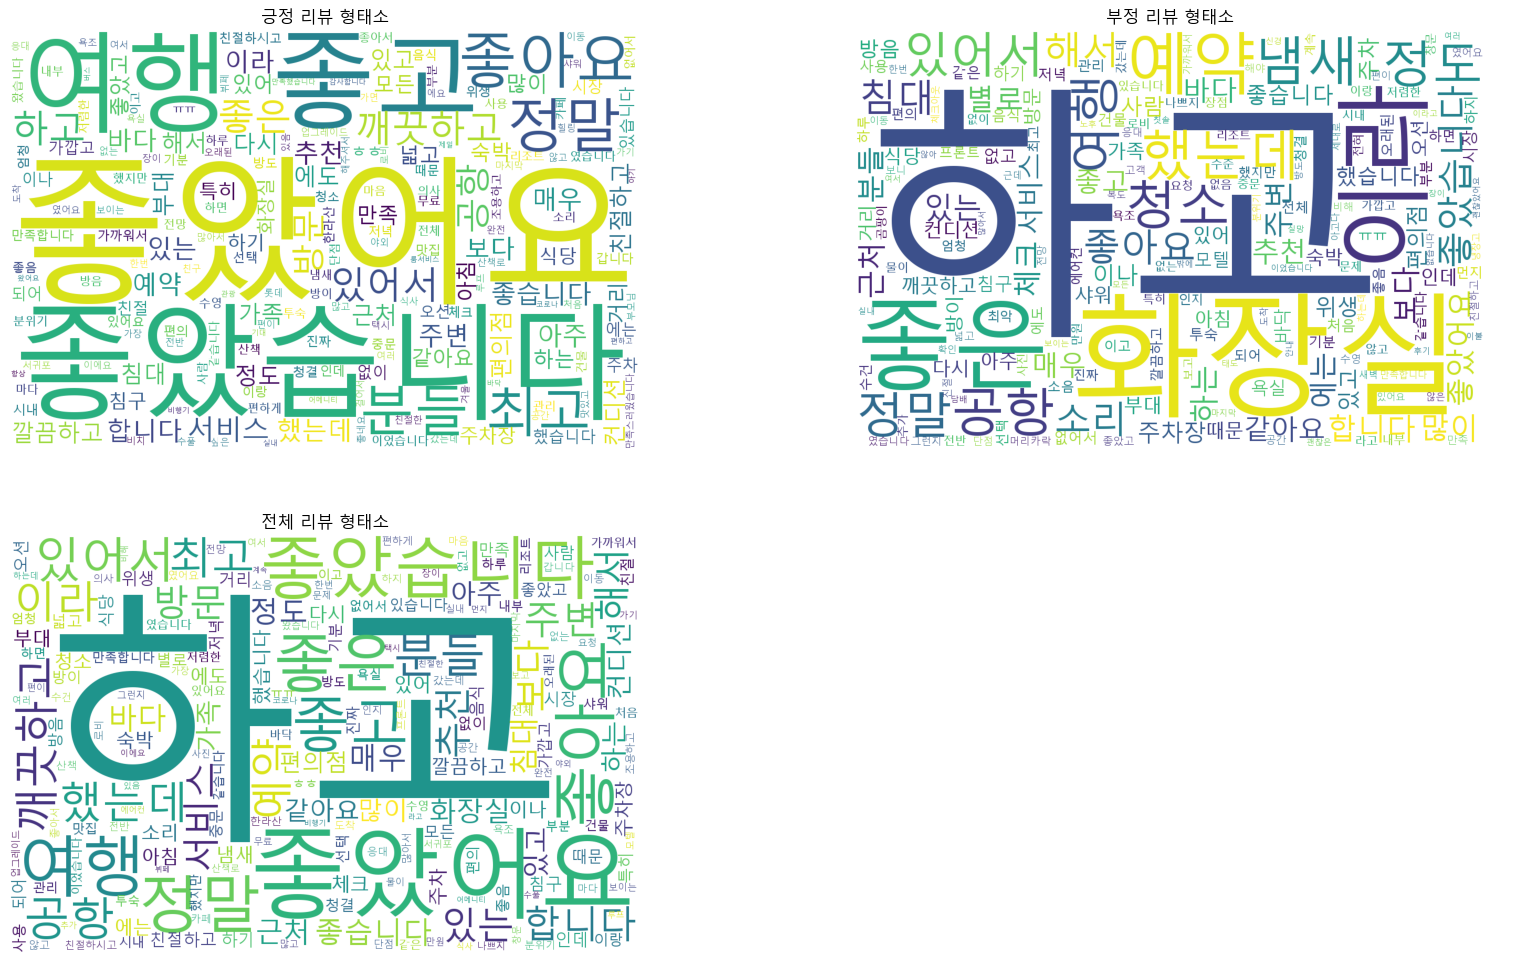

In [349]:
#불용문자 추가 형태소 워드클라우드
wc1=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=600, height=400, scale=2.0, max_font_size=250, background_color='white')
wc2=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=600, height=400, scale=2.0, max_font_size=250, background_color='white')
wc3=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=600, height=400, scale=2.0, max_font_size=250, background_color='white')
gen_morphs_stop=wc1.generate_from_frequencies(morphs_final)
gen_morphs_pos_stop=wc2.generate_from_frequencies(morphs_final_pos)
gen_morphs_neg_stop=wc3.generate_from_frequencies(morphs_final_neg)
# plt.imshow(gen_morphs_stop)
fig, axs = plt.subplots(2,2, figsize=(20,12))
axs[0][0].imshow(gen_morphs_pos_stop)
axs[0][1].imshow(gen_morphs_neg_stop)
axs[1][0].imshow(gen_morphs_stop)
axs[0,0].set_title("긍정 리뷰 형태소")
axs[0,0].axis('off')
axs[0,1].set_title("부정 리뷰 형태소")
axs[0,1].axis('off')
axs[1,0].set_title("전체 리뷰 형태소")
axs[1,0].axis('off')
axs[1,1].axis('off')
plt.show()



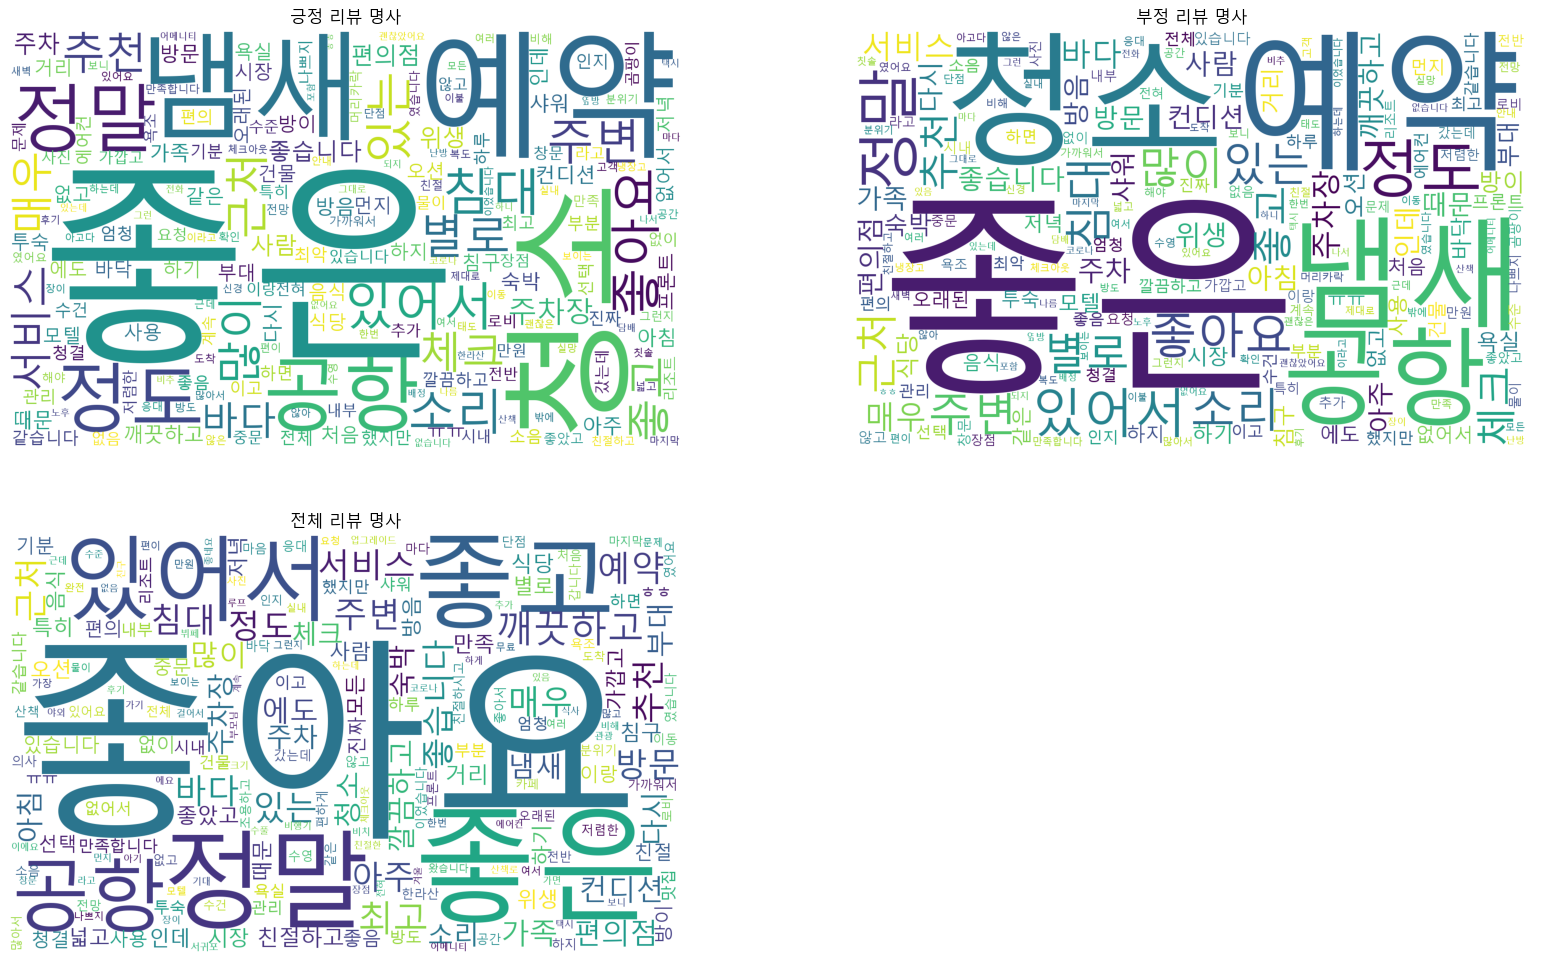

In [166]:
# 명사 불용문자 추가

wc4=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=800, height=500, scale=2.0, max_font_size=250, background_color='white')
wc5=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=800, height=500, scale=2.0, max_font_size=250, background_color='white')
wc6=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',width=800, height=500, scale=2.0, max_font_size=250, background_color='white')

gen_nouns_stop=wc4.generate_from_frequencies(nouns_final)
gen_nouns_pos_stop=wc5.generate_from_frequencies(nouns_final_pos)
gen_nouns_neg_stop=wc6.generate_from_frequencies(nouns_final_neg)

fig, axs = plt.subplots(2,2, figsize=(20,12))
axs[0][0].imshow(gen_nouns_pos_stop)
axs[0][1].imshow(gen_nouns_neg_stop)
axs[1][0].imshow(gen_nouns_stop)
axs[0,0].set_title("긍정 리뷰 명사")
axs[0,0].axis('off')
axs[0,1].set_title("부정 리뷰 명사")
axs[0,1].axis('off')
axs[1,0].set_title("전체 리뷰 명사")
axs[1,0].axis('off')
axs[1,1].axis('off')
plt.show()

---

### 평점별 (형태소)

In [61]:
# 평점 변환시 사용하기

std = 7  #기준값 설정
df["Point_index"] = [1. if point >= std else 0. for point in df["Point"]]


# df_pos = df[df['Point_index']==1] #긍정리뷰 데이터프레임
# df_neg = df[df['Point_index']==0] #부정리뷰 데이터프레임

# #인덱스별 분포 확인
# print("부정:",len(df_neg),"긍정:",len(df_pos))
# plt.figure(figsize=(6,4))
# sns.countplot(x=df['Point_index'])
# plt.show()

In [119]:
# 불용어 (https://www.ranks.nl/stopwords/korean) 불용어 리셋시 사용

korean_stopword='../stopwords.txt'

with open(korean_stopword, encoding='utf-8') as f:
    stopwords=f.readlines()

stoplist=[x.strip() for x in stopwords]

df['morphs3'] = df['morphs'].apply(lambda x : ' '.join([i for i in x if i not in stoplist]))
df['morphs3'] = df['morphs3'].apply(lambda x : ''.join([i for i in x if i not in string.punctuation]))

In [120]:
# 불용어 추가시 코드 실행
add_list=['제주도','호텔','숙소','가성','성비','대비','이용','제주','역시','생각','상태',
             '다만','바로','느낌','신라','직원','가격','위치','시설','조식','객실','그냥','입니다']

for word in add_list:
    stoplist.append(word)

morphs_final = Counter({x : remove_morphs_counter[x]for x in remove_morphs_counter if x not in stoplist})

df['morphs3'] = df['morphs'].apply(lambda x : ' '.join([i for i in x if i not in stoplist]))
df['morphs3'] = df['morphs3'].apply(lambda x : ''.join([i for i in x if i not in string.punctuation]))

In [121]:
import string
string.punctuation

#형태소
df['morphs3'] = df['morphs'].apply(lambda x : ' '.join([i for i in x if i not in stoplist]))
df['morphs3'] = df['morphs3'].apply(lambda x : ''.join([i for i in x if i not in string.punctuation]))

#명사
# df['nouns3'] = df['nouns'].apply(lambda x : ' '.join([i for i in x if i not in stoplist]))
# df['nouns3'] = df['nouns3'].apply(lambda x : ''.join([i for i in x if i not in string.punctuation]))

#9점이상 6점미만 데이터만 분류(학습용)
df2=copy.deepcopy(df)
df2=df2[(df2['Point']>=9)|(df2['Point']<6.5)] #해당 구간 변경하기

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

X3 = df2['morphs3'] # 9점 이상 6점 미만 형태소
# X4 = df2['nouns3']
y2 = df2['Point_index'] # 평점
X1 = df['morphs3'] # 전체 형태소
y = df['Point_index']


# Train data와 test data로 나누기

from sklearn.model_selection import train_test_split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y2, test_size = 0.2, random_state=13)
# X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y2, test_size = 0.2, random_state=13)



In [347]:
#평점 9점이상 6점미만 데이터만 사용

# 나이베이즈
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB() # alpha=0.5, fit_prior=True

model.fit(X3_train, y3_train)
pred = model.predict(X3_test)

print('나이베이즈 ')
print_clf_eval(y4_test, pred)

# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression
model2 = LogisticRegression()
model2.fit(X4_train,y4_train)
y_pred_test = model2.predict(X4_test)

print('로지스틱 회귀 ')
print_clf_eval(y4_test, pred)

# 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier

rf_clf=RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)
rf_clf.fit(X4_train, y4_train)
rf_pred=rf_clf.predict(X4_test)

print('랜덤포레스트 ')
print_clf_eval(y4_test, rf_pred)


나이베이즈 
=> confusion matrix
[[ 351  168]
 [  86 3219]]
Accuracy : 0.9336, Precision : 0.9504
Recall : 0.9740, F1 : 0.9620, Auc:0.8251
로지스틱 회귀 
=> confusion matrix
[[ 351  168]
 [  86 3219]]
Accuracy : 0.9336, Precision : 0.9504
Recall : 0.9740, F1 : 0.9620, Auc:0.8251
랜덤포레스트 
=> confusion matrix
[[ 215  304]
 [  69 3236]]
Accuracy : 0.9025, Precision : 0.9141
Recall : 0.9791, F1 : 0.9455, Auc:0.6967


# 검증

In [155]:
input='호텔의 모든 직원분들이 깔끔하고 전문적으로 응대해주셔서 굉장히 좋았습니다. 다만 아쉬운 점으로는 방의 티비가 켜지지 않았고, 콘센트도 한구 빼고는 작동하지 않았습니다. 잠시 머물더 가는거라 크게 신경쓰지 않으려했지만 아쉽네요. 시설점검이 더 자주 이루어져야 할것같아요'
input = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','',input)
tagger=Okt()
morphs=tagger.morphs(input)
morphs = [x for x in morphs if len(x) > 1]
morphs = [x for x in morphs if x not in stoplist]
morphs = [' '.join(morphs)]

n=vectorizer2.transform(morphs)
model.predict(n)

array([1.])

In [158]:
input='깔끔하고 위치도 훌륭햏어요 다음에 또 가고 싶은 호텔입니다'

def predict_str(input):
    input = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','',input)
    tagger=Okt()
    morphs=tagger.morphs(input)
    morphs = [x for x in morphs if len(x) > 1]
    morphs = [x for x in morphs if x not in stoplist]
    morphs = [' '.join(morphs)]

    n=vectorizer2.transform(morphs)
    predict=model3.predict(n)
    print(predict)

predict_str(input)

[1.]
